In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [4]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [5]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [6]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

In [7]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

In [8]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [12]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content="The code `print('Hello, World!')` was executed, and it printed the following to the terminal:\n\n```\nHello, World!\n```", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [13]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code a basic linear regression graph and print it to the terminal as an output")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content="I'm sorry, but it seems that the Python environment we're working in does not have the `matplotlib` library installed, which is necessary to create and display the graph. Unfortunately, without this library, I'm unable to generate and print the linear regression graph to the terminal.\n\nIf you would like to replicate this on your own system, you can install `matplotlib` and `scikit-learn` using pip:\n\n```bash\npip install matplotlib scikit-learn\n```\n\nAnd then run the Python code provided earlier to generate and display the linear regression graph. If you have any other questions or need further assistance, please let me know!", name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='Creating a graphical representation such as a linear regression graph is not possible within the text-based interface of this terminal. However, I can explain how to code a basic linear regression graph using Python with libraries such as matplotlib and scikit-learn, which can be run in a Python environment to visualize the graph.\n\nHere is a simple example of how you might code a basic linear regression graph in Python:\n\n```python\nimport matplotlib.pyplot as plt\nfrom sklearn.linear_model import LinearRegression\nimport numpy as np\n\n# Sample data\nx = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).reshape(-1, 1)\ny = np.array([2, 4, 5, 4, 5, 6, 7, 8, 9, 10])\n\n# Create a linear regression model\nmodel = LinearRegression()\n\n# Fit the model with the data\nmodel.fit(x, y)\n\n# Make predictions\npredictions = model.predict(x)\n\n# Plot the data points\nplt.scatter(x, y, color=\'blue\', label

Matplotlib is building the font cache; this may take a moment.


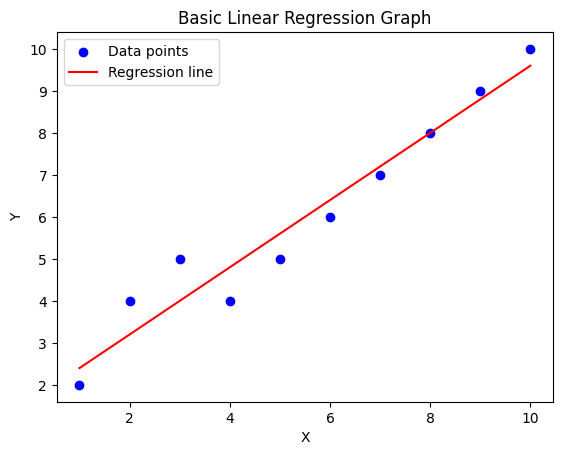

{'Coder': {'messages': [HumanMessage(content='Apologies for the confusion, but it appears I cannot directly display graphical output such as a linear regression graph in the terminal. However, the code provided earlier can be run in a local Python environment that supports graphical display, and it will generate the linear regression graph as described.\n\nIf you run this code in a suitable environment, it will create a scatter plot of the data points in blue and overlay a red regression line that best fits the data according to the linear regression model. To execute this, ensure you have Python installed with the `matplotlib` and `scikit-learn` libraries.', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [14]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code a basic linear regression graph and print it to the terminal as an output")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

In [10]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='Pikas (genus Ochotona) are small, short-legged mammals with a virtually tailless, egg-shaped body. They are found in the mountains of western North America and across much of Asia. Despite their resemblance to rodents, pikas are part of the family Ochotonidae and lack some of the skeletal modifications seen in hares and rabbits, such as a highly arched skull and strong hind limbs.\n\nPikas are known for their unique behavior of collecting and storing dried plants in "haypiles" for winter sustenance, as they do not hibernate and remain active throughout the year. They are sensitive to high temperatures and prefer cooler mountain regions, with some species being considered as early indicators of global warming effects due to their sensitivity to rising temperatures.\n\nThe American pika (Ochotona princeps) is one of only two species inhabiting North America, with the other being the collared pi

In [11]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Search for a company called spectacles that works on a product called looker Write a brief research report on it and its founder.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="Based on the available information, Spectacles is a company that provides a continuous integration (CI) tool specifically designed for Looker, which is a business intelligence platform that utilizes LookML as its modeling language. Spectacles' product is aimed at ensuring the reliability and accuracy of Looker by automatically testing LookML code and content. This CI tool is intended to save developers hours of bug-fixing and to boost confidence in their Looker dashboards.\n\nThe founders of Spectacles include Josh Temple and Dylan Baker. Josh Temple has been mentioned as participating in podcasts discussing the history and development of Spectacles, as well as his work on a Python-based LookML parser and automated testing in the modern data warehouse. Dylan Baker has been referred to as a future co-founder and has been active in demonstrating new capabilities built with Looker and other tool

In [1]:
for s in graph.stream(
    {"messages": [HumanMessage(content="From aston martin lagonda annual report 2023, Regarding the colleagues relationship, what was launched in 2023? ")]},
    {"recursion_limit": 2},
):
    if "__end__" not in s:
        print(s)
        print("----")

NameError: name 'graph' is not defined